In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import os
# Load dataset

script_dir = os.path.dirname(os.path.abspath(__file__))

# Build the full path to the dataset
dataset_path = os.path.join(script_dir, "TMDB_movie_dataset_v11.csv")
movies_df = pd.read_csv(dataset_path)


# Extract release year, decade, and month
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
movies_df['decade'] = (movies_df['release_year'] // 10) * 10
movies_df['month'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.month

# Filter dataset for valid years
movies_df = movies_df[(movies_df['release_year'] >= 1910) & (movies_df['release_year'] <= 2020)]

# Remove rows where revenue is <= 0
movies_df = movies_df[movies_df['revenue'] > 0]


high_revenue_threshold = movies_df['revenue'].quantile(0.97)

# Filter data to include only rows within this range
movies_df = movies_df[(movies_df['revenue'] <= high_revenue_threshold)]

movies_df = movies_df[movies_df['revenue'] <= high_revenue_threshold]

# Replace zero or negative budgets with the median budget
median_budget = movies_df[movies_df['budget'] > 0]['budget'].median()
movies_df['budget'] = movies_df['budget'].apply(lambda x: median_budget if x <= 0 else x)

# Create season columns
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return None

movies_df['season'] = movies_df['month'].apply(get_season)

# One-hot encode decades, seasons, and genres
decade_dummies = pd.get_dummies(movies_df['decade'], prefix='decade')
season_dummies = pd.get_dummies(movies_df['season'], prefix='season')
genre_dummies = movies_df['genres'].str.get_dummies(sep=', ')
print(genre_dummies)
# Add binary originally_english feature
movies_df['originally_english'] = (movies_df['original_language'] == 'en').astype(int)

# Add homepage feature
movies_df['has_homepage'] = movies_df['homepage'].notnull().astype(int)

# Extract and split production companies
movies_df['production_companies_list'] = movies_df['production_companies'].fillna('').apply(lambda x: x.split(', '))

# Calculate average revenue and movie count for each studio
studio_stats = (
    movies_df.explode('production_companies_list')
    .groupby('production_companies_list')
    .agg(
        avg_revenue=('revenue', 'mean'),
        movie_count=('revenue', 'count')
    )
    .sort_values(by='avg_revenue', ascending=False)
)

# Filter for studios with at least 10 movies
top_50_studios = studio_stats[studio_stats['movie_count'] >= 10].head(50).index

# Add a single binary column for whether a movie includes at least one of the top 50 studios
movies_df['has_top_50_studio'] = movies_df['production_companies_list'].apply(
    lambda x: int(any(studio in top_50_studios for studio in x))
)

# Add studio ranking feature based on average revenue
studio_rankings = studio_stats['avg_revenue'].rank(ascending=False)
movies_df['avg_studio_rank'] = movies_df['production_companies_list'].apply(
    lambda studios: np.mean([studio_rankings[studio] for studio in studios if studio in studio_rankings])
    if studios else np.nan
)

movies_df['log_budget'] = np.log1p(movies_df['budget'])
movies_df['log_runtime'] = np.log1p(movies_df['runtime'])
movies_df['log_vote_count'] = np.log1p(movies_df['vote_count'])
movies_df['log_vote_average'] = np.log1p(movies_df['vote_average'])
movies_df['log_avg_studio_rank'] = np.log1p(movies_df['avg_studio_rank'])



feature_set = pd.concat([
    decade_dummies,
    season_dummies,
    genre_dummies,
    movies_df[['log_budget', 'log_runtime', 'log_vote_count', 'log_vote_average', 'has_homepage', 'log_avg_studio_rank']]
], axis=1)


# Target variable: Log-transformed revenue
movies_df['log_revenue'] = np.log1p(movies_df['revenue'])
target = movies_df['log_revenue']
print(movies_df.count())

         Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
7             0          0          0       0      0            0      1   
9             0          0          0       0      1            0      0   
14            0          0          0       0      1            0      1   
21            0          0          0       0      0            0      1   
53            0          0          0       0      1            0      1   
...         ...        ...        ...     ...    ...          ...    ...   
1140624       0          0          0       0      0            0      1   
1141137       0          0          0       1      0            0      0   
1141830       0          0          0       1      0            1      0   
1141883       0          0          0       0      0            1      0   
1143026       0          0          0       0      0            0      1   

         Family  Fantasy  History  Horror  Music  Mystery  Romance  \
7             0  

In [29]:
avg_log_vote_count = movies_df['log_vote_count'].mean()
avg_log_vote_average = movies_df['log_vote_average'].mean()
avg_log_avg_studio_rank = movies_df['log_avg_studio_rank'].mean()

# Print the results
print("Average log_vote_count:", avg_log_vote_count)
print("Average log_vote_average:", avg_log_vote_average)
print("Average log_avg_studio_rank:", avg_log_avg_studio_rank)

Average log_vote_count: 4.421377370877335
Average log_vote_average: 1.8090426941019961
Average log_avg_studio_rank: 8.388421486384377


In [34]:
import numpy as np
average_revenue = movies_df['revenue'].mean()
print(f"Average Revenue: {average_revenue:.2f}")


# Calculate Pearson correlations
budget_correlation = movies_df['budget'].corr(movies_df['revenue'])
log_budget_correlation = np.log1p(movies_df['budget']).corr(np.log1p(movies_df['revenue']))
runtime_correlation = movies_df['runtime'].corr(movies_df['revenue'])
log_runtime_correlation = np.log1p(movies_df['runtime']).corr(np.log1p(movies_df['revenue']))
homepage_corr = movies_df['has_homepage'].corr(movies_df['revenue'])

vote_count_corr = movies_df['vote_count'].corr(movies_df['revenue'])
vote_average_corr = movies_df['vote_average'].corr(movies_df['revenue'])
log_vote_count_corr = np.log1p(movies_df['vote_count']).corr(np.log1p(movies_df['revenue']))
log_vote_average_corr = np.log1p(movies_df['vote_average']).corr(np.log1p(movies_df['revenue']))
studio_corr = movies_df['avg_studio_rank'].corr(movies_df['revenue'])
log_studio_corr = np.log1p(movies_df['avg_studio_rank']).corr(np.log1p(movies_df['revenue']))
top_50_studios_corr = movies_df['has_top_50_studio'].corr(np.log1p(movies_df['revenue']))



# Print correlations
print(f"Correlation between top_50_studios and revenue: {top_50_studios_corr:.4f}")
print(f"Correlation between vote count and revenue: {vote_count_corr:.4f}")
print(f"Correlation between vote average and revenue: {vote_average_corr:.4f}")
print(f"Correlation between log vote count and Log revenue: {log_vote_count_corr:.4f}")
print(f"Correlation between log vote average and Log revenue: {log_vote_average_corr:.4f}")
print(f"Correlation between having a homepage and revenue: {homepage_corr:.4f}")
print(f"Pearson Correlation (Normal Budget vs. Revenue): {budget_correlation:.4f}")
print(f"Pearson Correlation (Log Budget vs. Log Revenue): {log_budget_correlation:.4f}")
print(f"Pearson Correlation (Runtime vs. Revenue): {runtime_correlation:.4f}")
print(f"Pearson Correlation (Log Runtime vs. Log Revenue): {log_runtime_correlation:.4f}")
print(f"Correlation between average studio rank and revenue: {studio_corr:.4f}")
print(f"Correlation between  Log average studio rank and Log revenue: {studio_corr:.4f}")



Average Revenue: 23696821.22
Correlation between top_50_studios and revenue: 0.2436
Correlation between vote count and revenue: 0.6371
Correlation between vote average and revenue: 0.1623
Correlation between log vote count and Log revenue: 0.7037
Correlation between log vote average and Log revenue: 0.4284
Correlation between having a homepage and revenue: 0.1700
Pearson Correlation (Normal Budget vs. Revenue): 0.6627
Pearson Correlation (Log Budget vs. Log Revenue): 0.6922
Pearson Correlation (Runtime vs. Revenue): 0.1718
Pearson Correlation (Log Runtime vs. Log Revenue): 0.4829
Correlation between average studio rank and revenue: -0.5017
Correlation between  Log average studio rank and Log revenue: -0.5017


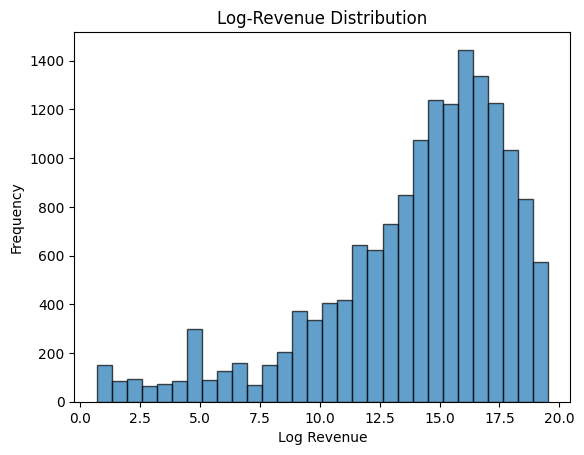

revenue_bin
Very Low     3203
Low          3202
Medium       3202
High         3202
Very High    3202
Name: count, dtype: int64
Bin Cutoffs:
Very Low: 0.00 to 89237.00
Low: 89237.00 to 1325092.00
Medium: 1325092.00 to 7033683.00
High: 7033683.00 to 30995924.00
Very High: 30995924.00 to 300855000.00


In [ ]:
#CREATING BUCKETS FOR MY RANDOM TREES MODEL


import matplotlib.pyplot as plt

plt.hist(np.log1p(movies_df['revenue']), bins=30, edgecolor='k', alpha=0.7)
plt.title("Log-Revenue Distribution")
plt.xlabel("Log Revenue")
plt.ylabel("Frequency")
plt.show()

# Define bins based on revenue quantiles
quantiles = movies_df['revenue'].quantile([0.2, 0.4, 0.6, 0.8]).values
bins = [0] + quantiles.tolist() + [movies_df['revenue'].max()]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
bin_cutoffs = {labels[i]: (bins[i], bins[i+1]) for i in range(len(bins) - 1)}

# Create a categorical column for bins
movies_df['revenue_bin'] = pd.cut(movies_df['revenue'], bins=bins, labels=labels, include_lowest=True)

# Check distribution of bins
print(movies_df['revenue_bin'].value_counts())
print("Bin Cutoffs:")
for i in range(len(bins) - 1):
    
    print(f"{labels[i]}: {bins[i]:.2f} to {bins[i+1]:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode revenue_bin to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(movies_df['revenue_bin'])  # Encode target bins as integers

# Define features and encoded target
X = feature_set  # Assuming feature_set is already prepared
y = y_encoded  # Encoded numerical labels

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Decode predictions and test set back to categorical values
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f"\nQuadratic Weighted Kappa: {qwk:.2f}")

# Proximity-Aware Weighted Accuracy
def weighted_accuracy(y_true, y_pred):
    # Calculate the proximity score: closer bins get higher weight
    return np.mean(1 - np.abs(y_true - y_pred) / (y_true.max() - y_true.min()))

weighted_acc = weighted_accuracy(y_test, y_pred)
print(f"\nWeighted Accuracy: {weighted_acc:.2f}")




# COMMENTED OUT BECAUSE OF THE MAKEFILE RUNNING IT
# joblib.dump(clf, "random_forest_model.pkl")

# Save the Label Encoder
#joblib.dump(label_encoder, "label_encoder.pkl")

#print("Model and encoder saved successfully.")



Accuracy: 0.6412738058070558

Classification Report:
              precision    recall  f1-score   support

        High       0.54      0.64      0.58       672
         Low       0.56      0.65      0.61       622
      Medium       0.50      0.45      0.47       646
   Very High       0.80      0.79      0.80       632
    Very Low       0.89      0.67      0.77       631

    accuracy                           0.64      3203
   macro avg       0.66      0.64      0.65      3203
weighted avg       0.66      0.64      0.64      3203


Quadratic Weighted Kappa: 0.54

Weighted Accuracy: 0.81
Model and encoder saved successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import joblib  # For saving the model

# Filter rows with complete data
final_df = pd.concat([feature_set, target], axis=1).dropna()

# Adjust train-test split for the dataset
X = final_df.iloc[:, :-1]  # Features
y = final_df.iloc[:, -1]   # Log-transformed target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Define XGBoost and hyperparameters
param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.1, 0.05],
    'max_depth': [6, 8],
}

# GridSearchCV to find the best hyperparameters
xgb_model = xgb.XGBRegressor(random_state=42)
grid = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

# Best XGBoost model and hyperparameters
best_xgb_model = grid.best_estimator_
print(f"Best hyperparameters for XGBoost: {grid.best_params_}")

# Save the best model
#joblib.dump(best_xgb_model, "best_xgb_model.pkl")
#print("\nBest XGBoost model saved as 'best_xgb_model.pkl'.")

# Predict and evaluate the model
y_pred_log = best_xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))
print(f"XGBoost RMSE (original scale): {rmse_original:.2f}")



Best hyperparameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

Best XGBoost model saved as 'best_xgb_model.pkl'.
XGBoost RMSE (original scale): 25849667.89


In [ ]:
pd.set_option('display.float_format', '{:,.2f}'.format)
comparison_df = pd.DataFrame({
    'Actual Revenue': y_test_original,
    'Predicted Revenue': y_pred
})

# Display 50 examples
print(comparison_df.head(50))

         Actual Revenue  Predicted Revenue
241143           300.00              10.27
75585        147,131.00          46,416.02
346       86,758,912.00      99,025,384.00
402       55,736,588.00      48,595,956.00
65426      6,779,794.00       2,346,263.25
108552       339,486.00         284,160.41
54139         10,832.00          12,671.49
11081     66,293,455.00      34,586,316.00
8967       2,750,275.00       1,067,437.75
1121254        6,104.00           3,577.86
68434      2,362,000.00         918,936.38
1231      75,462,037.00      38,407,972.00
28092      3,333,306.00       2,974,521.00
45517      2,916,444.00         345,470.19
2526      72,436,439.00      55,103,628.00
16958        702,001.00       2,291,575.50
32502      6,000,000.00       4,917,752.50
1126      51,973,029.00      34,028,812.00
5111       9,494,789.00      19,830,136.00
17962     13,300,000.00       4,171,258.75
326332        15,000.00          13,829.04
301879       126,667.00          50,949.25
77801      